In [1]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np

# REF_PATH : reference dataset path
# CONFUSION_PATH : benchmark1
# EXCHANGE_PATH : benchmark2

REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CONFUSION_PATH = "/home/yifan/dataset/confusion/pairflip/cifar10/0"
EXCHANGE_PATH = "/home/yifan/dataset/exchange/pairflip/cifar10/0"

sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
clean_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

confusion_provider = NormalDataProvider(CONFUSION_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

exchange_provider = NormalDataProvider(EXCHANGE_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)


ref_train_data = ref_provider.train_representation(200).squeeze()

confusion_data = confusion_provider.train_representation(200).squeeze()

exchange_data = exchange_provider.train_representation(200).squeeze()

clean_data = clean_provider.train_representation(200).squeeze()

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [5]:
from scipy.special import softmax
pred = ref_provider.get_pred(200, ref_train_data)

# scores = np.amax(softmax(pred, axis=1), axis=1)


def filter_conf(pred, conf_min, conf_max):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    res = np.argwhere(np.logical_and(scores<=conf_max, scores>=conf_min)).squeeze().tolist()
    return res
scores = filter_conf(pred, 0, 0.9)
print("scores",scores)

100%|██████████| 250/250 [00:00<00:00, 9366.72it/s]

scores [1316, 1370, 1745, 3785, 4483, 5530, 5645, 5709, 6062, 6281, 7179, 8259, 8458, 9316, 10143, 10584, 10932, 11876, 11977, 12491, 12673, 12770, 13591, 14663, 15091, 17920, 22239, 22456, 23370, 23424, 23848, 24161, 24650, 25676, 27898, 28835, 28914, 29666, 30200, 31578, 32970, 33572, 33721, 33775, 35162, 36107, 36527, 37466, 38286, 38729, 38775, 38941, 39487, 39824, 39833, 41454, 42033, 43768, 44143, 44354, 45625, 45779, 46503, 46748, 47554, 48298]


Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 781.06it/s]


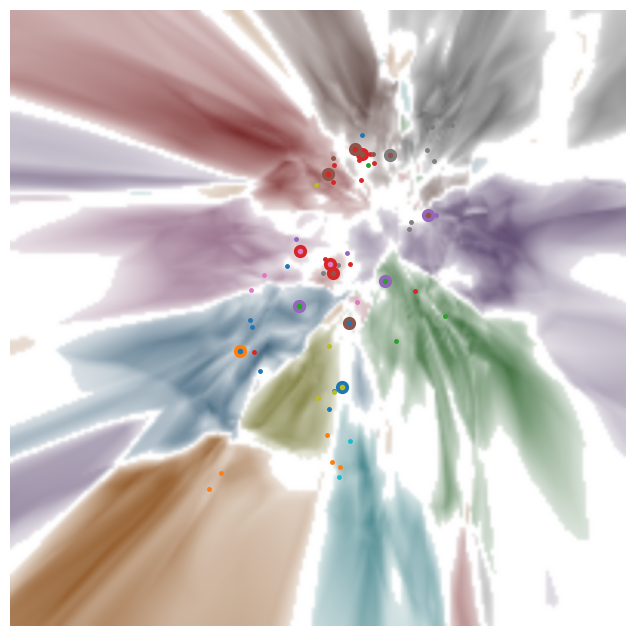

In [6]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.initial_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_provider.train_representation(200), projector, 200,scores,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))


In [ ]:
from scipy.special import softmax
pred_c = clean_provider.get_pred(200, clean_data)

# scores = np.amax(softmax(pred, axis=1), axis=1)


def filter_conf(pred, conf_min, conf_max):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    res = np.argwhere(np.logical_and(scores<=conf_max, scores>=conf_min)).squeeze().tolist()
    return res
scores_c = filter_conf(pred_c, 0.9, 1)
print("scores",scores_c)

In [24]:
import json
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)

from scipy.special import softmax
pred_trans = clean_provider.get_pred(200, np.dot(ref_train_data, RT))

# scores = np.amax(softmax(pred, axis=1), axis=1)


def filter_conf(pred, conf_min, conf_max):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    res = np.argwhere(np.logical_and(scores<=conf_max, scores>=conf_min)).squeeze().tolist()
    return res
iii = filter_conf(pred_trans, 0, 0.4)
print("scores",len(iii))



100%|██████████| 250/250 [00:00<00:00, 9417.11it/s]

scores 14


Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 1504.95it/s]


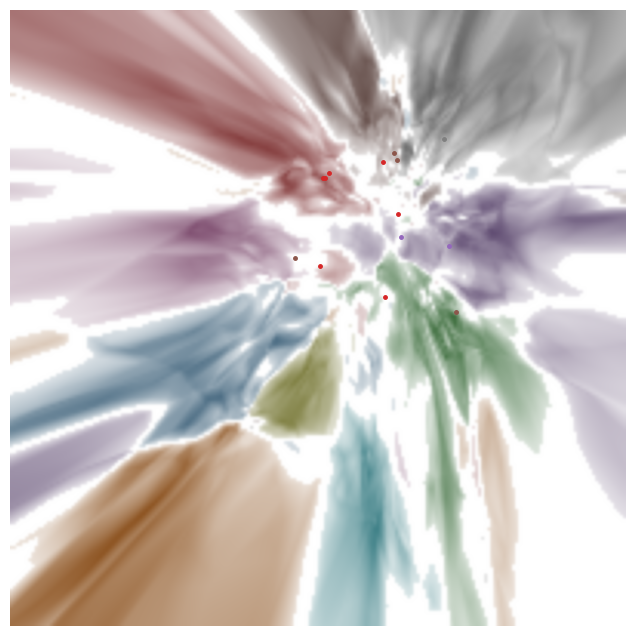

In [25]:
I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer-
vis = visualizer(clean_provider, RT,I, np.dot(clean_provider.train_representation(200),R), projector, 200,iii,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 6009.03it/s]


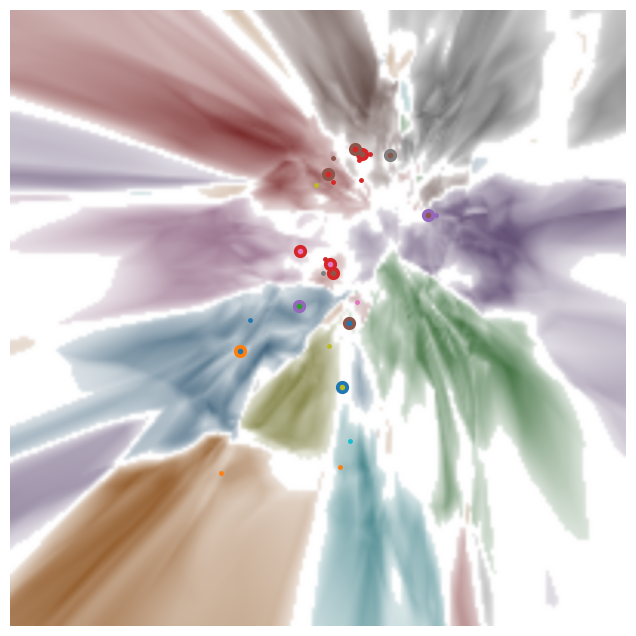

In [7]:

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.initial_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_provider.train_representation(200), projector, 200,scores,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.initial_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_provider.train_representation(200), projector, 200, c_scores,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_train_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [12]:
from representationTrans.reference_transformer import ReferenceTransformer
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
transformer = ReferenceTransformer(clean_provider,projector,ref_provider)
list1 = transformer.get_new_ref_by_tar_knn(200, 5)

100%|██████████| 250/250 [00:00<00:00, 9444.67it/s]


Sun Jan  1 01:46:19 2023 Building RP forest with 16 trees
Sun Jan  1 01:46:20 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	 4  /  16
	 5  /  16
	Stopping threshold met -- exiting after 5 iterations


In [13]:
list1[619]

array([0.47553056, 0.91365016, 0.51621276, 2.1538265 , 0.08940348,
       0.35690182, 0.8440118 , 0.        , 2.1170292 , 1.2118645 ,
       0.3598133 , 3.2318268 , 0.        , 0.        , 1.0553066 ,
       0.2977573 , 0.68185747, 2.2678552 , 0.        , 3.1189263 ,
       0.51041734, 0.03408656, 1.7969143 , 0.22813664, 0.5448148 ,
       0.        , 2.3254538 , 1.8164537 , 1.6329871 , 0.6617814 ,
       1.5273873 , 0.09151558, 0.        , 0.05273813, 1.7774167 ,
       0.        , 1.1159526 , 0.813131  , 0.        , 1.2671603 ,
       0.        , 0.09641554, 0.11958046, 0.04404182, 0.14106704,
       1.2828778 , 0.799124  , 0.        , 1.5367862 , 1.2882161 ,
       0.39708745, 4.1785517 , 0.95216095, 0.2949739 , 0.19920926,
       0.8942631 , 0.1874313 , 1.0926397 , 0.14289755, 2.1721478 ,
       1.933273  , 0.6480267 , 1.2111484 , 0.67359364, 0.92409265,
       0.48483032, 1.2006292 , 1.0056692 , 0.        , 0.9333701 ,
       3.0643013 , 0.69138384, 0.        , 0.7407905 , 1.73271

In [2]:
ref_pred = ref_provider.get_pred(200,  ref_provider.train_representation(200))
clean_pred = clean_provider.get_pred(200,  clean_provider.train_representation(200))
ref_pred = ref_pred.argmax(axis=1)
clean_pred = clean_pred.argmax(axis=1)
diff_list = []
for i in range(len(ref_pred)):
    if ref_pred[i] != clean_pred[i]:
        diff_list.append(i)
print(len(diff_list))
for k in range(len(diff_list)):
    index = diff_list[k]
    # print("index", index, 'ref label',ref_provider.train_labels(200)[index],'ref_pred:',ref_pred[index], 'clean label',clean_provider.train_labels(200)[index],'clean_pred:',clean_pred[index])

100%|██████████| 250/250 [00:00<00:00, 9458.30it/s]

71


In [3]:
 from pynndescent import NNDescent
 from sklearn.utils import check_random_state
 from umap.umap_ import fuzzy_simplicial_set

 def _construct_fuzzy_complex(n_neighbors, train_data):
        """
        construct a vietoris-rips complex
        """
        # number of trees in random projection forest
        n_trees = min(64, 5 + int(round((train_data.shape[0]) ** 0.5 / 20.0)))
        # max number of nearest neighbor iters to perform
        n_iters = max(5, int(round(np.log2(train_data.shape[0]))))
        # distance metric
        metric = "euclidean"
        # get nearest neighbors
        nnd = NNDescent(
            train_data,
            n_neighbors=n_neighbors,
            metric=metric,
            n_trees=n_trees,
            n_iters=n_iters,
            max_candidates=60,
            verbose=True
        )
        knn_indices, knn_dists = nnd.neighbor_graph
        random_state = check_random_state(None)
        complex, sigmas, rhos = fuzzy_simplicial_set(
            X=train_data,
            n_neighbors=n_neighbors,
            metric=metric,
            random_state=random_state,
            knn_indices=knn_indices,
            knn_dists=knn_dists,
        )
        return complex, sigmas, rhos, knn_indices
tar_complex, tar_sigmas, tar_rhos, tar_knn_indices = _construct_fuzzy_complex(2, ref_provider.train_representation(200))
# ref_complex, ref_sigmas, ref_rhos, ref_knn_indices = _construct_fuzzy_complex(2, clean_provider.train_representation(200))

Sun Jan  1 01:42:31 2023 Building RP forest with 16 trees
Sun Jan  1 01:42:32 2023 NN descent for 16 iterations
	 1  /  16
	 2  /  16
	 3  /  16
	Stopping threshold met -- exiting after 3 iterations


In [51]:
tar_knn_indices[8259]

array([ 8259, 26135], dtype=int32)

In [64]:
diff_list =[8259, 13247,26135]

In [5]:
import json
newtrain = clean_provider.train_representation(200)
for k in range(len(diff_list)):
    index = diff_list[k]
    nearest_index_in_tar = tar_knn_indices[index][1]
    # print(index,nearest_index_in_tar)
    newtrain[index] = clean_provider.train_representation(200)[nearest_index_in_tar]
 
    # print('index',index, 'tar',tar_knn_indices[index],'ref', ref_knn_indices[index])
# filename = now = time.strftime("clean_as_ref_epoch_200.json", time.localtime(time.time())) 
# rlist = json.dumps(newtrain.tolist())
# with open(filename, 'w', encoding='utf-8') as file_obj:

#     file_obj.write(rlist)

print(newtrain)


[[0.         0.         1.3862395  ... 2.01611    0.6060404  0.4670472 ]
 [2.3884826  1.8559968  0.6663851  ... 0.6170911  2.1145046  1.7129223 ]
 [1.6156454  2.0472403  0.9266379  ... 0.25885504 1.1148586  1.2194152 ]
 ...
 [2.3992484  2.402385   0.5422969  ... 0.09138229 0.8866464  1.4071962 ]
 [1.6172862  0.22004734 1.036005   ... 2.0317147  0.6698662  1.9716433 ]
 [0.8757368  0.45541143 0.51799047 ... 0.16303115 0.88168585 2.3847365 ]]


In [9]:
diff_list

[619,
 973,
 1316,
 2747,
 2833,
 3359,
 5077,
 5645,
 7508,
 7810,
 8157,
 8259,
 9132,
 9316,
 9745,
 10584,
 11038,
 11136,
 12779,
 14647,
 14977,
 15658,
 16535,
 17704,
 17920,
 18387,
 18957,
 19549,
 20209,
 21262,
 21324,
 22456,
 23348,
 23370,
 23477,
 23859,
 25359,
 26927,
 27059,
 27496,
 28148,
 29333,
 29548,
 29638,
 29689,
 30135,
 30802,
 31156,
 31903,
 33465,
 33710,
 33750,
 35162,
 36127,
 36676,
 37466,
 38089,
 38941,
 39487,
 39833,
 41489,
 41498,
 42194,
 43160,
 45777,
 46181,
 46503,
 46683,
 47391,
 47454,
 49774]

In [10]:
newtrain[619]

array([0.05215247, 0.68106306, 0.871322  , 1.5472544 , 0.29287767,
       0.6401359 , 0.20205201, 0.0931468 , 2.144931  , 0.6667918 ,
       0.21055155, 2.3733344 , 0.3614036 , 0.20643325, 0.5016743 ,
       0.7566798 , 0.2090267 , 3.3112235 , 0.        , 2.5815468 ,
       0.33672032, 0.17725343, 0.35303503, 0.2967255 , 0.92471266,
       0.47687602, 1.5208223 , 0.57498044, 0.8238513 , 0.59043753,
       1.3885393 , 0.71215934, 0.        , 0.44482106, 0.18036613,
       0.32777423, 0.24536154, 0.61510617, 0.41523424, 0.840508  ,
       0.7046174 , 0.28341016, 0.01755507, 0.35492563, 0.        ,
       0.6486362 , 1.1599749 , 0.11628859, 2.1556096 , 1.245554  ,
       1.2169682 , 1.9276817 , 0.7645425 , 0.        , 0.35925546,
       1.2029735 , 0.8847689 , 1.038246  , 0.        , 2.1243255 ,
       2.1808114 , 1.2690481 , 0.47723374, 1.2372789 , 1.3871024 ,
       0.81320393, 0.9912399 , 1.0333247 , 0.00748179, 0.70157677,
       2.1386876 , 0.3770277 , 0.        , 0.8258749 , 1.19569

In [11]:
clean_provider.train_representation(200)[619]

array([3.32873493e-01, 8.06102037e-01, 8.20962548e-01, 2.11642814e+00,
       1.18924908e-01, 6.34109437e-01, 1.22483957e+00, 1.57134280e-01,
       1.21461236e+00, 9.67555761e-01, 3.96538317e-01, 3.19747424e+00,
       6.77086592e-01, 1.58706129e-01, 5.22500038e-01, 1.04556334e+00,
       2.46013671e-01, 3.12343311e+00, 0.00000000e+00, 5.03984690e+00,
       9.43755627e-01, 1.49012208e-01, 9.44292426e-01, 1.11775562e-01,
       1.04128981e+00, 0.00000000e+00, 1.77552104e+00, 1.93461132e+00,
       3.87419939e-01, 9.18432355e-01, 1.31785774e+00, 1.07033722e-01,
       0.00000000e+00, 5.90487756e-02, 1.43205059e+00, 6.05151393e-02,
       1.18246770e+00, 2.81651258e-01, 2.94616316e-02, 8.88409138e-01,
       0.00000000e+00, 5.39347053e-01, 2.99421310e-01, 4.10561189e-02,
       1.07481308e-01, 1.45238161e+00, 1.06040204e+00, 8.61746669e-02,
       1.66325951e+00, 7.67150521e-01, 4.68640149e-01, 3.12122464e+00,
       2.59120584e-01, 1.67804673e-01, 5.91658771e-01, 1.34025455e+00,
      

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 4815.50it/s]


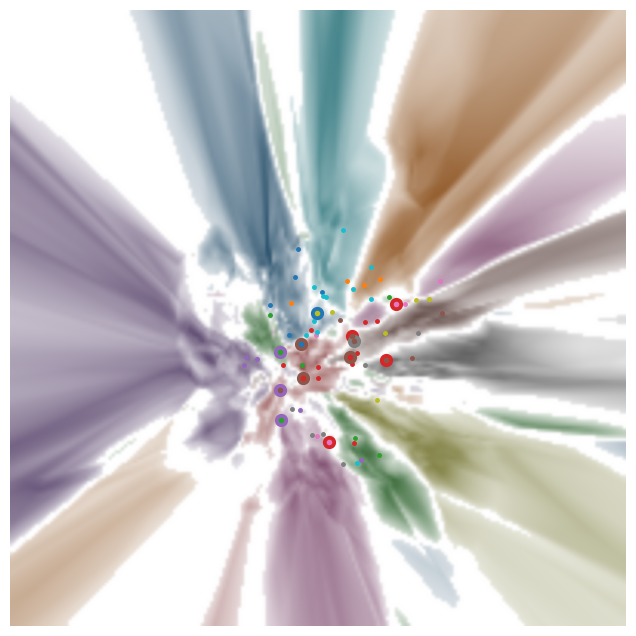

In [5]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
with open('benchmark2_R_ref_clean_tar_ref_use_trans.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark2_RT_ref_clean_tar_ref_use_trans.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer-
vis = visualizer(ref_provider, RT,I, np.dot(ref_provider.train_representation(200),R), projector, 200,diff_list,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5622.39it/s]


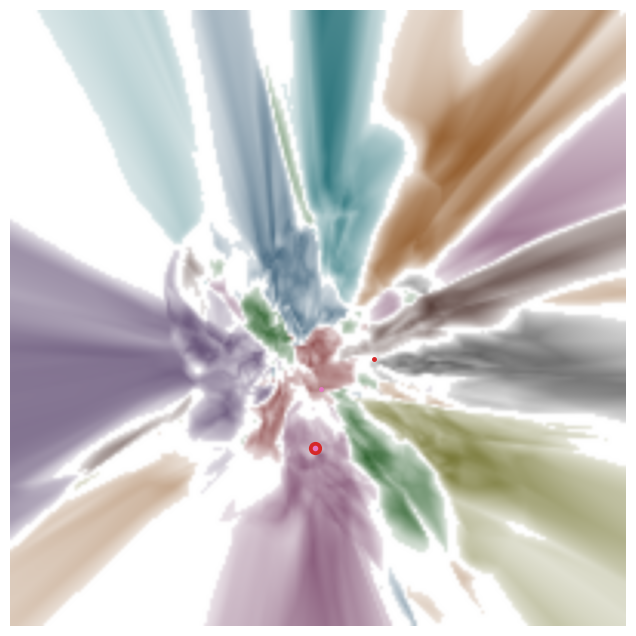

In [66]:
import json
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
with open('benchmark1_RT_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    R = json.load(file_obj)
with open('benchmark1_R_ref_ref_tar_clean.json', 'r', encoding='utf-8') as file_obj:
    RT = json.load(file_obj)
I = np.eye(512)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, RT,I, np.dot(ref_provider.train_representation(200),R), projector, 200,diff_list,'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9348.18it/s]


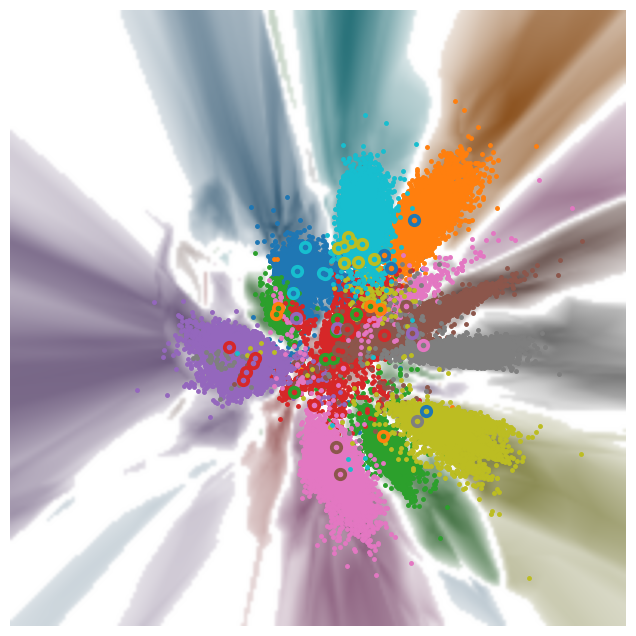

In [63]:
with open('clean_as_ref_epoch_200.json', 'r', encoding='utf-8') as file_obj:
    A = json.load(file_obj)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.initial_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_provider, np.array(A), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 250/250 [00:00<00:00, 9334.53it/s]


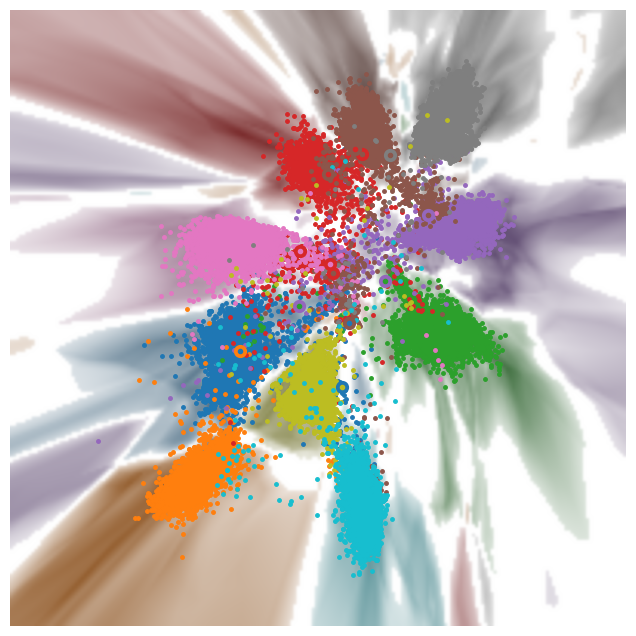

In [62]:
with open('clean_as_ref_epoch_200.json', 'r', encoding='utf-8') as file_obj:
    A = json.load(file_obj)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.initial_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, ref_provider.train_representation(200), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))